In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns

In [22]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)

In [23]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_alig', 'Flux_density', 
             'Width', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Energy', 
             'Polar_l',  'Polar_c', 'RM_syn',  'RM_QUfit', 'Scatt_t', 'Scin_f',]

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if type(value)==str and len(value.strip()) > 0:
        try:
            if '/' in value:
                value = value.split('/')[0]
            if '-' in value and not '+' in value:
                value = value.split('-')[0]
            if value[0] == '+':
                value = value[1:]
                value.split('/')
                value = value[0]
            if value[0] == '<':
                value = value[1:]
            if value[0] == '>':
                value = value[1:]
            return float(value)
        except:
            print(f"Error: {value}")
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

for col in frb_data[features].columns:
    frb_data[col] = frb_data[col].apply(clean_numeric_value)

frb_data['DM_SNR']

Error: paper
Error: 10, 9
Error: 8, 12
Error: 1.05, 0.6, 1.2
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Error: 
Err

0       565.1
1       559.9
2       560.0
3       566.0
4       560.5
        ...  
8659    527.9
8660    527.8
8661    527.6
8662    527.3
8663    527.3
Name: DM_SNR, Length: 8664, dtype: float64

In [24]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Split the data into training and validation sets (e.g., 80% training, 20% validation)
train_data, val_data = train_test_split(frb_data_scaled, test_size=0.2, random_state=42)

# Convert the data into PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)

# Create datasets and dataloaders for training and validation
batch_size = 64  # Adjust as needed
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(VAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        # Modified Decoder Design
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )

    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [26]:
reconstruction_loss_fn = torch.nn.MSELoss(reduction='sum')

def loss_function(recon_x, x, mean, logvar):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
patience = 4
num_epochs = 150


model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [0/6931 (0%)]	Loss: 15.691637
Train Epoch: 1 [6400/6931 (92%)]	Loss: 13.384089
====> Epoch: 1 Average training loss: 19.4531, Reconstruction loss: 16.5210
====> Validation loss: 16.3011, Reconstruction loss: 13.7312
New best model saved with validation loss: 16.3011
Train Epoch: 2 [0/6931 (0%)]	Loss: 16.473383
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.874958
====> Epoch: 2 Average training loss: 15.9384, Reconstruction loss: 12.3940
====> Validation loss: 15.2455, Reconstruction loss: 12.1412
New best model saved with validation loss: 15.2455
Train Epoch: 3 [0/6931 (0%)]	Loss: 19.311249
Train Epoch: 3 [6400/6931 (92%)]	Loss: 10.578900
====> Epoch: 3 Average training loss: 14.6132, Reconstruction loss: 10.8079
====> Validation loss: 14.3122, Reconstruction loss: 11.4434
New best model saved with validation loss: 14.3122
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.210772
Train Epoch: 4 [6400/6931 (92%)]	Loss: 12.220497
====> Epoch: 4 Average training loss: 13.9870, Reconstructio

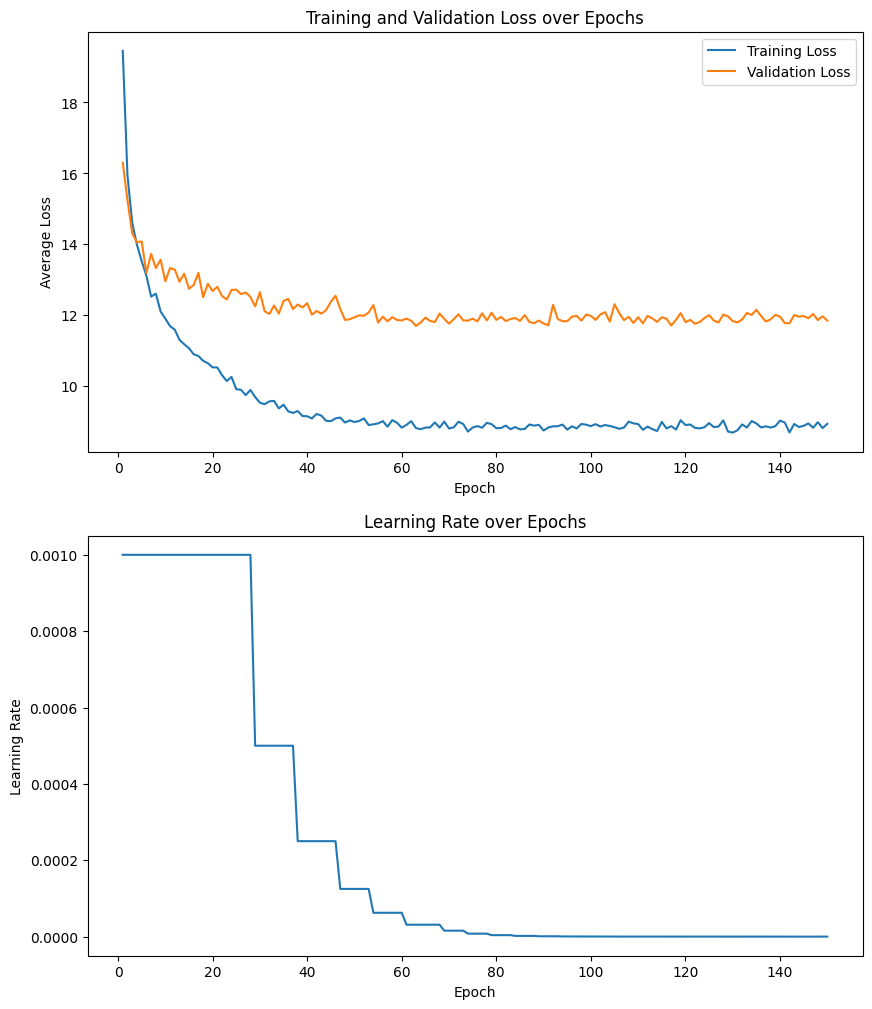

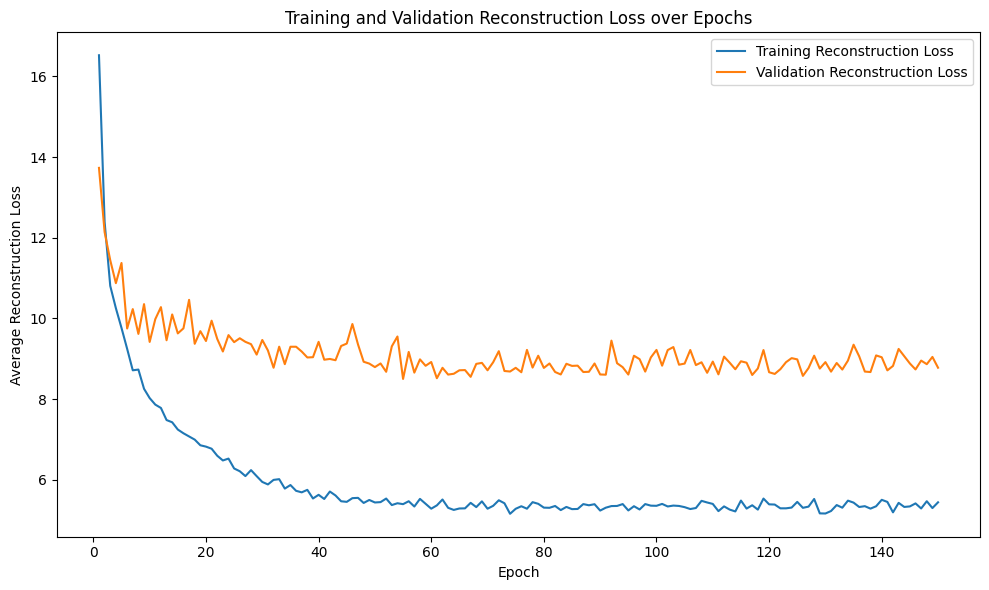

In [28]:
# Train loop
def train(epoch):
    model.train()
    train_loss = 0
    recon_loss = 0
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        full_loss, recon_loss_val, kl_loss = loss_function(recon_batch, data, mu, logvar)
        full_loss.backward()
        train_loss += full_loss.item()
        recon_loss += recon_loss_val.item()  # Ensure recon_loss is a float, not tensor
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {full_loss.item() / len(data):.6f}')

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average training loss: {avg_loss:.4f}, Reconstruction loss: {avg_recon_loss:.4f}')
    return avg_loss, avg_recon_loss

# Validation loop
def validate():
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    with torch.no_grad():
        for (data,) in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            full_loss, recon_loss_val, kl_loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += full_loss.item()
            val_recon_loss += recon_loss_val.item()  # Ensure recon_loss is a float, not tensor

    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon_loss = val_recon_loss / len(val_loader.dataset)
    print(f'====> Validation loss: {avg_loss:.4f}, Reconstruction loss: {avg_recon_loss:.4f}')
    return avg_loss, avg_recon_loss

# Early stopping function
def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False

# Initialize training variables
best_loss = float('inf')
train_losses, val_losses, learning_rates = [], [], []
train_recon_losses, val_recon_losses = [], []

# Training loop with early stopping and learning rate scheduling
for epoch in range(1, num_epochs + 1):
    train_loss, train_recon_loss = train(epoch)
    val_loss, val_recon_loss = validate()
    
    # Track losses and learning rates
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    train_recon_losses.append(train_recon_loss)
    val_recon_losses.append(val_recon_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'vae_best.pth')
        print(f"New best model saved with validation loss: {best_loss:.4f}")
    
    # Early stopping
    if early_stopping(val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training complete.")

# Plot the training and validation loss and learning rate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(learning_rates) + 1), learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

# Plot the training and validation reconstruction loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(1, len(train_recon_losses) + 1), train_recon_losses, label='Training Reconstruction Loss')
ax.plot(range(1, len(val_recon_losses) + 1), val_recon_losses, label='Validation Reconstruction Loss')
ax.set_title('Training and Validation Reconstruction Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reconstruction Loss')
ax.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_281245/3088663518.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], cmap='tab10')


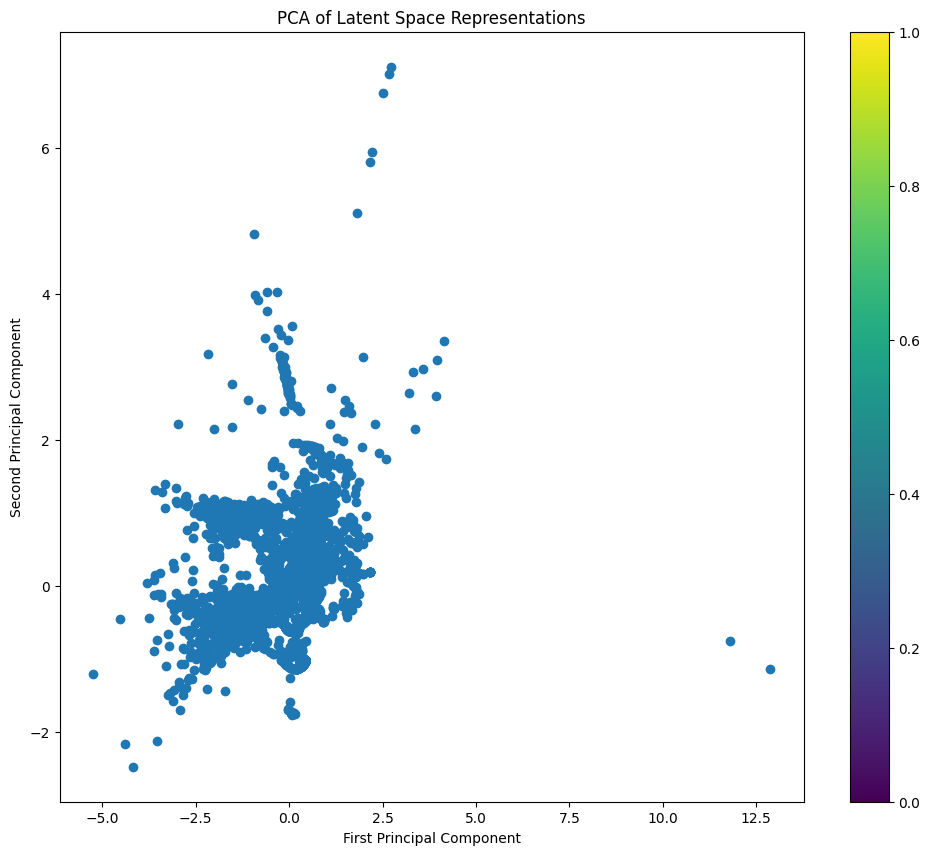

<Figure size 2000x2000 with 0 Axes>

In [35]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    with torch.no_grad():
        for data, in dataloader:
            data = data.view(data.size(0), -1).to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
    return np.concatenate(latent_representations)


def visualize_latent_space_pca(latent_representations, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], cmap='tab10')
    plt.colorbar(scatter)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

    # Visualize generated numbers in the 2D latent space
    plt.figure(figsize=(20, 20))
    x_min, x_max = latent_2d[:, 0].min() - 1, latent_2d[:, 0].max() + 1
    y_min, y_max = latent_2d[:, 1].min() - 1, latent_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
    
    plt.tight_layout()
    plt.show()

latent_representations = get_latent_representations(model, train_loader, device)
visualize_latent_space_pca(latent_representations, model, device)

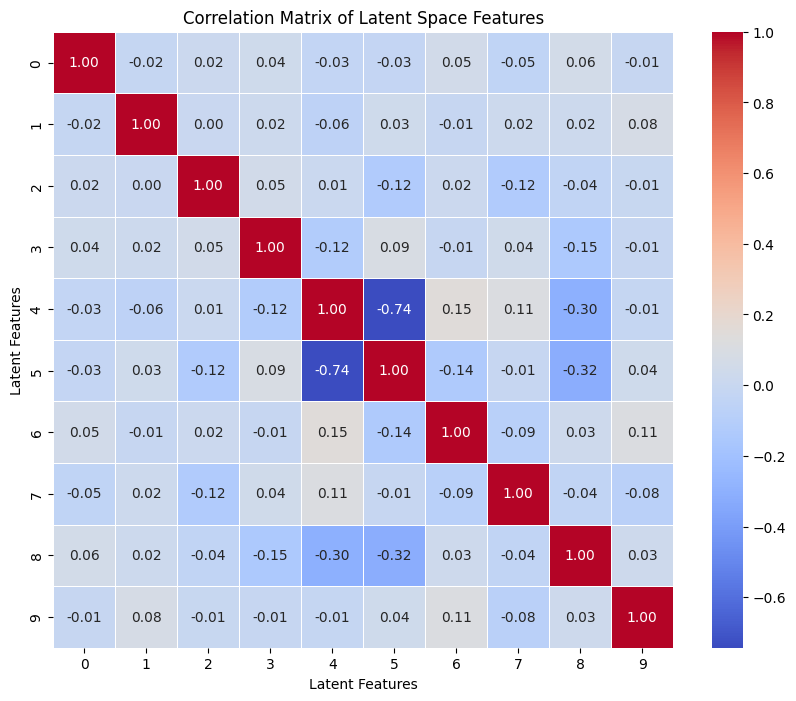

In [36]:
# Step 1: Calculate the correlation matrix
correlation_matrix = np.corrcoef(latent_representations, rowvar=False)

# Step 2: Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Latent Space Features')
plt.xlabel('Latent Features')
plt.ylabel('Latent Features')
plt.show()

In [37]:
torch.save(model.state_dict(), 'frb_vae_model.pth')

In [40]:
def decode_specific_latent_features(model, latent_vector, feature_indices, device):

    modified_latent_vector = latent_vector.clone().detach()
    
    # Set all other features except those in feature_indices to zero
    for i in range(latent_vector.size(1)):  # latent_vector.size(1) gives the latent_dim size
        if i not in feature_indices:
            modified_latent_vector[:, i] = 0  # Set to zero to neutralize other features
    
    # Decode the modified latent vector to get the reconstructed data
    reconstructed_data = model.decode(modified_latent_vector.to(device))
    
    return reconstructed_data

with torch.no_grad():
    sample_data = next(iter(train_loader))[0].to(device)  # Get one batch of input data
    mu, _ = model.encode(sample_data)  # Encode to get the mean latent vector
    
    reconstructed_data = decode_specific_latent_features(model, mu, [4, 5], device)

In [41]:
reconstructed_data_np = reconstructed_data.cpu().numpy()
recon_data_df = pd.DataFrame(reconstructed_data_np, columns=features)
recon_data_df.head()

,Observing_band,MJD,GL,GB,SNR,DM_SNR,DM_alig,Flux_density,Width,Freq_high,Freq_low,Freq_peak,Fluence,Energy,Polar_l,Polar_c,RM_syn,RM_QUfit,Scatt_t,Scin_f
0,-0.422347,0.015902,-0.357437,-0.126052,-0.032635,-0.065933,-0.217118,-0.042702,0.029276,-0.244790,-0.271309,-0.209999,-0.001172,-0.152175,-0.155665,-0.301866,-0.044840,-0.033651,-0.005283,-0.057262
1,-0.421826,0.015815,-0.357343,-0.125689,-0.033203,-0.065839,-0.217200,-0.042976,0.028677,-0.244983,-0.271480,-0.210141,-0.001576,-0.152344,-0.156618,-0.302202,-0.044626,-0.032862,-0.005272,-0.057293
2,-0.422904,0.016111,-0.357721,-0.126664,-0.031793,-0.065802,-0.216986,-0.042263,0.030198,-0.244509,-0.271066,-0.209817,-0.000561,-0.151862,-0.154229,-0.301361,-0.045123,-0.034699,-0.005291,-0.057215
3,-0.422719,0.015956,-0.357504,-0.126338,-0.032242,-0.065982,-0.217110,-0.042489,0.029709,-0.244620,-0.271152,-0.209892,-0.000875,-0.152032,-0.155006,-0.301623,-0.045012,-0.034211,-0.005293,-0.057233
4,-0.423147,0.016142,-0.357891,-0.127265,-0.031502,-0.065508,-0.217436,-0.041863,0.030732,-0.244043,-0.270592,-0.209665,-0.000169,-0.151460,-0.153720,-0.301072,-0.045467,-0.035166,-0.005309,-0.057124


In [42]:
threshold = 0.1
columns_to_drop = [col for col in recon_data_df.columns if abs(recon_data_df[col][0]) < threshold]

recon_df_cleaned = recon_data_df.drop(columns=columns_to_drop)

recon_df_cleaned.head()

,Observing_band,GL,GB,DM_alig,Freq_high,Freq_low,Freq_peak,Energy,Polar_l,Polar_c
0,-0.422347,-0.357437,-0.126052,-0.217118,-0.244790,-0.271309,-0.209999,-0.152175,-0.155665,-0.301866
1,-0.421826,-0.357343,-0.125689,-0.217200,-0.244983,-0.271480,-0.210141,-0.152344,-0.156618,-0.302202
2,-0.422904,-0.357721,-0.126664,-0.216986,-0.244509,-0.271066,-0.209817,-0.151862,-0.154229,-0.301361
3,-0.422719,-0.357504,-0.126338,-0.217110,-0.244620,-0.271152,-0.209892,-0.152032,-0.155006,-0.301623
4,-0.423147,-0.357891,-0.127265,-0.217436,-0.244043,-0.270592,-0.209665,-0.151460,-0.153720,-0.301072
